# Reading a .txt adjacency matrix

In [169]:
import numpy as np
import time
import random

def read_adjacency_matrix(filename):
    with open(filename, 'r') as file:
        # Read the first line which contains the number of cities
        n = int(file.readline().strip())

        # Initialize an empty matrix
        adj_matrix = []

        # Read the remaining lines and populate the adjacency matrix
        for _ in range(n):
            row = list(map(float, file.readline().strip().split()))
            adj_matrix.append(row)

    return adj_matrix, n

# Nearest Neighbors: NN

In [170]:
# Define the Nearest Neighbor Algorithm
def NN(adj_matrix, total_cities, start_city = 0):
  # Set of unvisited cities
  unvisited = set(range(total_cities))
  # Start the tour from the start city, default is A (0)
  tour = [start_city]
  # Remove the starting city from the unvisited set
  unvisited.remove(start_city)
  # Initialize the total tour distance and nodes expanded
  total_distance = 0
  nodes_expanded = 0

  current_city = start_city

  while unvisited:
    # Find the nearest unvisited city in the set
    nearest_city = min(unvisited, key=lambda city: adj_matrix[current_city][city])
    # Increment total distance by the distance between current and nearest city
    total_distance += adj_matrix[current_city][nearest_city]
    # Append the nearest city to the tour
    tour.append(nearest_city)
    # Remove the nearest city from the unvisited cities set
    unvisited.remove(nearest_city)
    # Move to the nearest city and repeat
    current_city = nearest_city
    # Increment nodes expanded
    nodes_expanded += 1

  # Return to the starting city
  total_distance += adj_matrix[current_city][start_city]
  # Complete the tour by appending starting city
  tour.append(start_city)

  return tour, total_distance, nodes_expanded

# Nearest Neighbor 2-OPT: NN2O

In [171]:
# Helper function that performs 2-opt swap by reversing the order of nodes between v1 and v2.
def two_opt_swap(route, v1, v2):
    if v1 > v2:
        v1, v2 = v2, v1  # Ensure v1 is smaller than v2
    new_route = route[:v1 + 1]  # Route from start to v1
    new_route += route[v1 + 1:v2 + 1][::-1]  # Reverse the segment from v1+1 to v2
    new_route += route[v2 + 1:]  # Route from v2+1 to end
    return new_route

# Helper function that calculates the total distance of the given route.
def calculate_total_distance(adj_matrix, route):
    total_distance = 0
    for i in range(len(route) - 1):
        total_distance += adj_matrix[route[i]][route[i + 1]]
    total_distance += adj_matrix[route[-1]][route[0]]  # Return to start city
    return total_distance


# Helper function that iteratively optimizes the route using the 2-opt algorithm.
def two_opt(adj_matrix, route):
  # best_distance = calculateTotalDistance(existing_route)
  best_distance = calculate_total_distance(adj_matrix, route)
  # start_again:
  while True:
    improved = False
    # for (i = 0; i <= number of nodes eligible to be swapped - 1; i++)
    for i in range(1, len(route) - 1):
      # for (j = i + 1; j <= number of nodes eligible to be swapped; j++)
      for j in range(i + 1, len(route)):
        # new_route = 2optSwap(existing_route, i, j)
        new_route = two_opt_swap(route, i, j)
        # new_distance = calculateTotalDistance(new_route)
        new_distance = calculate_total_distance(adj_matrix, new_route)

        #  if (new_distance < best_distance)
        if new_distance < best_distance:
          # existing_route = new_route
          route = new_route
          #  best_distance = new_distance
          best_distance = new_distance
          improved = True
          # goto start_again
          break  # Exit the inner loop if an improvement is found
      if improved:
        break  # Exit the outer loop and restart the search
      if not improved:
        break  # No more improvements, exit the loop
    return route, best_distance

# Define the Nearest Neighbors with 2-Opt Algorithm
def NN2O(adj_matrix, total_cities, start_city = 0):
  route, total_distance, nodes_expanded = NN(adj_matrix, total_cities, start_city)
  opt_route, opt_total_distance = two_opt(adj_matrix, route)
  return opt_route, opt_total_distance, nodes_expanded

# Randomized Nearest Neighbor: RNN

In [172]:
# Helper function that runs modified NN with random starting node and selecting
def randomised_nearest_neighbor(adj_matrix, total_cities, num_nearest, start_city = 0):
  # Set of unvisited cities
    unvisited = set(range(total_cities))
    # Start the tour from the start city, default is A (0)
    tour = [start_city]
    # Remove the starting city from the unvisited set
    unvisited.remove(start_city)
    # Initialize the total tour distance and nodes expanded
    total_distance = 0
    nodes_expanded = 0

    current_city = start_city

    while unvisited:
      # Find the num_nearest nearest unvisited cities in the set
      nearest_cities = sorted(unvisited, key=lambda city: adj_matrix[current_city][city])[:num_nearest]
      # Randomly select one of the nearest cities
      nearest_city = random.choice(nearest_cities)
      # Increment total distance by the distance between current and nearest city
      total_distance += adj_matrix[current_city][nearest_city]
      # Append the nearest city to the tour
      tour.append(nearest_city)
      # Remove the nearest city from the unvisited cities set
      unvisited.remove(nearest_city)
      # Move to the nearest city and repeat
      current_city = nearest_city
      # Increment nodes expanded
      nodes_expanded += 1

    # Return to the starting city
    total_distance += adj_matrix[current_city][start_city]
    # Complete the tour by appending starting city
    tour.append(start_city)

    return tour, total_distance, nodes_expanded

# Repeated Randomized Nearest Neighbors with 2-Opt
def RNN(adj_matrix, total_cities, num_nearest = 2, num_restarts = 50):
    best_tour = None
    best_cost = float('inf')

    for _ in range(num_restarts):
        # Start with a random city
        start_city = random.randint(0, len(adj_matrix) - 1)
        # Generate a randomised nearest neighbour tour
        tour, cost, nodes = randomised_nearest_neighbor(adj_matrix, total_cities, num_nearest, start_city)

        # Optimize the tour with 2-opt
        optimized_tour, optimized_cost = two_opt(adj_matrix, tour)

        # Update the best solution
        if optimized_cost < best_cost:
            best_tour = optimized_tour
            best_cost = optimized_cost

    return best_tour, best_cost, nodes

# Compute each family's average/min/max of total cost, number of nodes, CPU, and real-time runtime

In [173]:
# Run NN, NN2O, and RNN algorithms and return their results.
def run_algorithms(adj_matrix, total_cities):

    results = {}

    # Run Nearest Neighbor
    start_time = time.time()
    nn_route, nn_cost, nn_nodes_expanded = NN(adj_matrix, total_cities)
    nn_cpu_time = time.process_time()
    nn_real_time = time.time() - start_time
    results['NN'] = (nn_cost, nn_nodes_expanded, nn_cpu_time, nn_real_time)

    # Run Nearest Neighbor + 2-Opt
    start_time = time.time()
    nn2o_route, nn2o_cost, nn2o_nodes_expanded = NN2O(adj_matrix, total_cities)
    nn2o_cpu_time = time.process_time()
    nn2o_real_time = time.time() - start_time
    results['NN2O'] = (nn2o_cost, nn2o_nodes_expanded, nn2o_cpu_time, nn2o_real_time)

    # Run Randomized NN + 2-Opt
    start_time = time.time()
    rnn_route, rnn_cost, rnn_nodes_expanded = RNN(adj_matrix, total_cities, num_nearest=2, num_restarts=50)
    rnn_cpu_time = time.process_time()
    rnn_real_time = time.time() - start_time
    results['RNN'] = (rnn_cost, rnn_nodes_expanded, rnn_cpu_time, rnn_real_time)

    return results

In [174]:
import pandas as pd
import matplotlib.pyplot as plt

# Data collection
all_results = []
sizes = ['05', '10', '15', '20', '25', '30']
nums = ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30']

graphs = []
for size in sizes:
  for num in nums:
    filename = f'/content/infile{size}_{num}.txt'
    adj_matrix, total_cities = read_adjacency_matrix(filename)
    graphs.append((adj_matrix, total_cities))


for graph, n in graphs:
    results = run_algorithms(graph, n)
    for alg, (cost, nodes, cpu_time, real_time) in results.items():
        all_results.append({
            'Algorithm': alg,
            'Size': n,
            'Nodes_Expanded': nodes,
            'TotalCost': cost,
            'CPUTime': cpu_time,
            'RealTime': real_time
        })

# Convert to DataFrame for easier analysis
df = pd.DataFrame(all_results)

# Compute average, min, and max for each graph size and algorithm
stats = df.groupby(['Size', 'Algorithm']).agg({
    'TotalCost': ['mean', 'min', 'max'],
    'Nodes_Expanded': ['mean', 'min', 'max'],
    'CPUTime': ['mean', 'min', 'max'],
    'RealTime': ['mean', 'min', 'max']
}).reset_index()


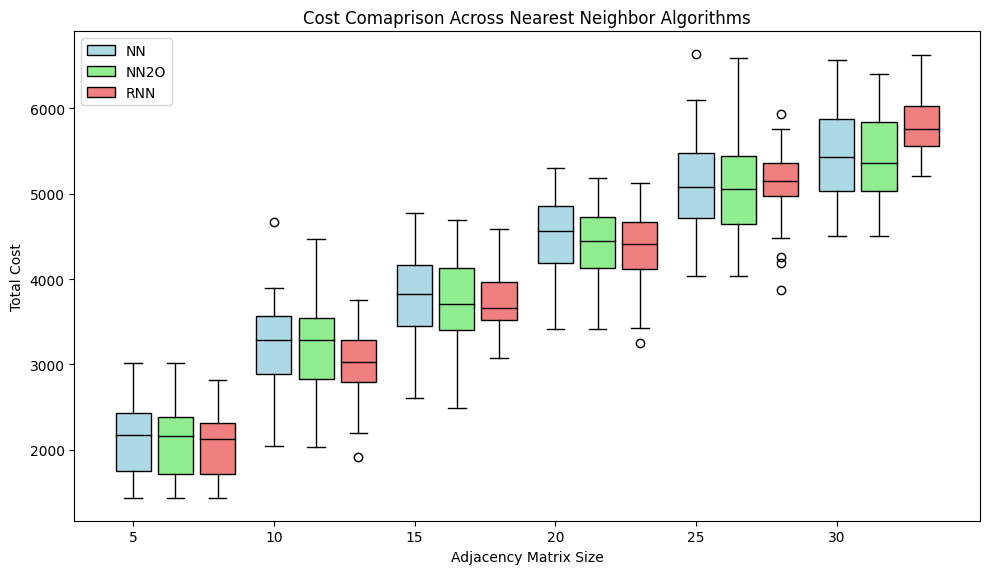

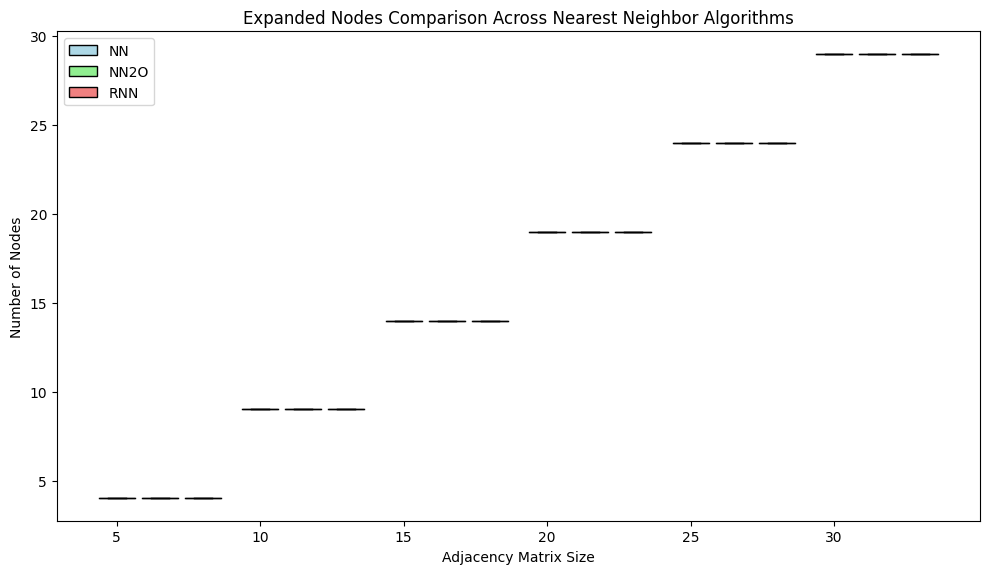

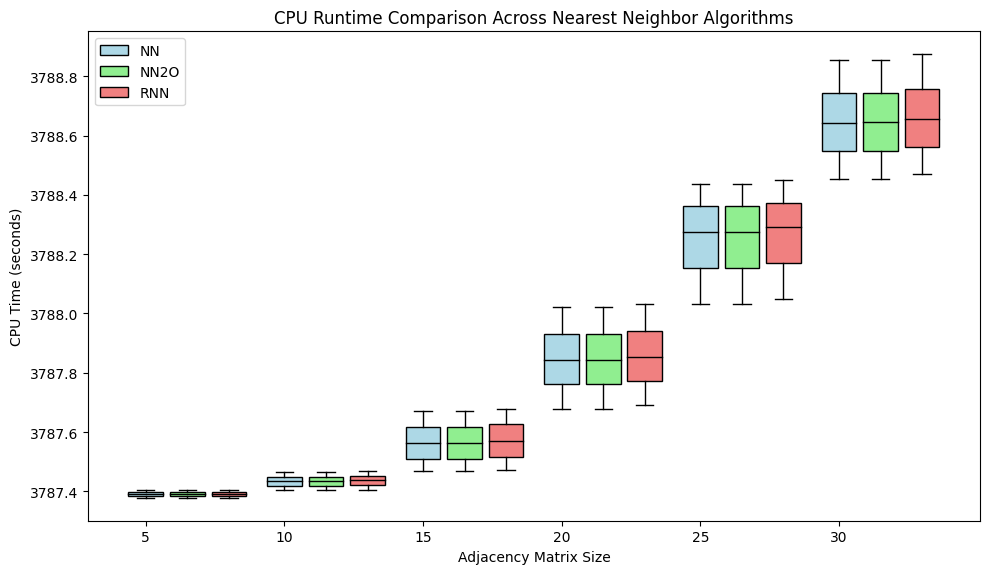

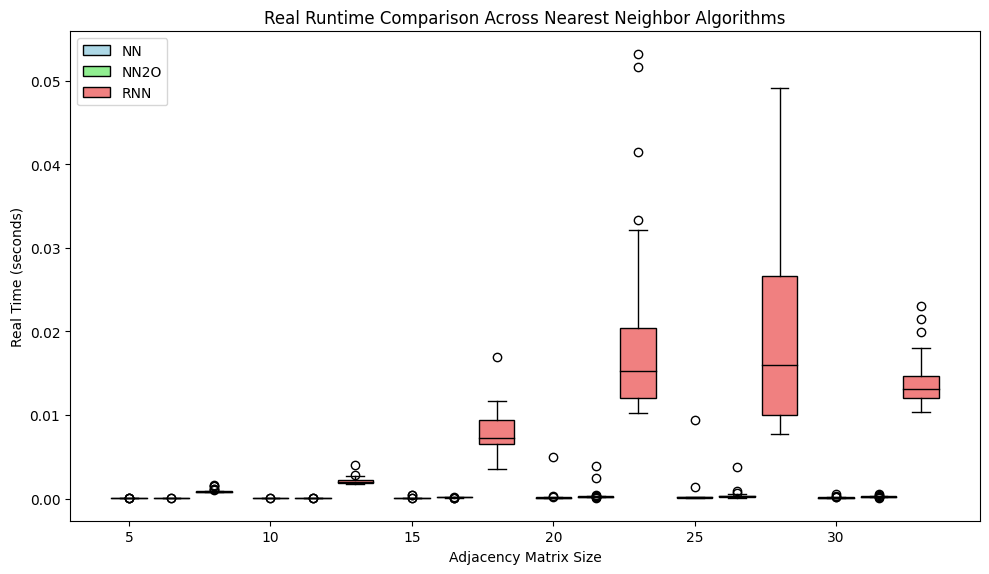

In [175]:
def plot_box_plots(df, metric, title, ylabel):
    # Define a color palette for each algorithm
    algorithm_colors = {
        'NN': 'lightblue',
        'NN2O': 'lightgreen',
        'RNN': 'lightcoral'
    }

    # Prepare a figure
    plt.figure(figsize=(10, 6))

    # Get the unique node sizes and algorithms
    size = df['Size'].unique()
    algorithms = df['Algorithm'].unique()

    # Create a list to store plot handles for the legend
    plot_handles = []

    # Iterate through algorithms and add box plots for each
    for algorithm in algorithms:
        # Filter the dataframe by the current algorithm
        data = df[df['Algorithm'] == algorithm]

        # Create a boxplot for the current algorithm, colored accordingly
        box = plt.boxplot(
            [data[data['Size'] == n][metric] for n in size],
            positions=np.arange(len(size)) + (0.3 * list(algorithms).index(algorithm)),
            widths=0.25,
            patch_artist=True,
            boxprops=dict(facecolor=algorithm_colors[algorithm], color='black'),
            medianprops=dict(color='black'),
            whiskerprops=dict(color='black'),
            capprops=dict(color='black'),
            flierprops=dict(markeredgecolor='black'),
            manage_ticks=False
        )

        # Store the handle for the legend
        plot_handles.append(box["boxes"][0])

    # Set x-axis labels
    plt.xticks(np.arange(len(size)), labels=size)

    # Title and labels
    plt.title(title)
    plt.suptitle('')  # Remove automatic matplotlib title
    plt.xlabel("Adjacency Matrix Size")
    plt.ylabel(ylabel)

    # Add legend
    plt.legend(plot_handles, algorithms, loc='upper left')

    # Show the plot
    plt.tight_layout()
    plt.show()

# Plot box plots for total cost, CPU time, and real time
plot_box_plots(df, 'TotalCost', 'Cost Comaprison Across Nearest Neighbor Algorithms', 'Total Cost')
plot_box_plots(df, 'Nodes_Expanded', 'Expanded Nodes Comparison Across Nearest Neighbor Algorithms', 'Number of Nodes')
plot_box_plots(df, 'CPUTime', 'CPU Runtime Comparison Across Nearest Neighbor Algorithms', 'CPU Time (seconds)')
plot_box_plots(df, 'RealTime', 'Real Runtime Comparison Across Nearest Neighbor Algorithms', 'Real Time (seconds)')


# A_MST

In [176]:
import heapq

# Compute the MST (Minimum Spanning Tree) using Prim's Algorithm
def compute_mst(adj_matrix, unvisited):
    n = len(adj_matrix)
    if not unvisited:
        return 0
    visited = set([next(iter(unvisited))])  # Start from an arbitrary unvisited node
    mst_cost = 0
    edges = []

    while len(visited) < len(unvisited):
        for u in visited:
            for v in unvisited:
                if v not in visited and u != v:
                    heapq.heappush(edges, (adj_matrix[u][v], u, v))

        while edges:
            cost, u, v = heapq.heappop(edges)
            if v not in visited:
                visited.add(v)
                mst_cost += cost
                break
    return mst_cost

# A* search for TSP with MST heuristic
def A_MST(adj_matrix):
    n = len(adj_matrix)
    start_city = 0
    nodes_expanded = 0
    goal_state = (1 << n) - 1  # All cities visited state, represented as bitmask (e.g., 1111 for 4 cities)

    # Priority queue for A*, stores (f(n), g(n), current_city, visited_state, path)
    pq = []
    heapq.heappush(pq, (0, 0, start_city, 1 << start_city, [start_city]))

    while pq:
        f, g, current_city, visited_state, path = heapq.heappop(pq)

        # Check if all cities have been visited (goal state)
        if visited_state == goal_state:
            # Add the cost of returning to the start city to complete the tour
            return path + [start_city], g + adj_matrix[current_city][start_city], nodes_expanded

        # Generate successors (next cities to visit)
        unvisited = {i for i in range(n) if not (visited_state & (1 << i))}
        for next_city in unvisited:
            new_visited_state = visited_state | (1 << next_city)
            new_g = g + adj_matrix[current_city][next_city]

            # Compute heuristic h(n) as the MST of the remaining unvisited cities
            mst_cost = compute_mst(adj_matrix, unvisited)
            new_f = new_g + mst_cost

            heapq.heappush(pq, (new_f, new_g, next_city, new_visited_state, path + [next_city]))
            nodes_expanded += 1

    return None, float('inf'), 0  # No solution found

# Compute difference between each family's average/min/max of total cost and number of nodes from each part 1 algorithm and optimal cost from A* with MST

In [177]:
# Run NN, NN2O, RNN, and A_MST algorithms and subtract then return their results.
def run_algorithms(adj_matrix, total_cities):

    results = {}

    # Run A_MST
    amst_route, amst_cost, amst_nodes_expanded = A_MST(adj_matrix)

    # Run Nearest Neighbor
    nn_route, nn_cost, nn_nodes_expanded = NN(adj_matrix, total_cities)
    results['NN - A_MST'] = (nn_cost - amst_cost, amst_nodes_expanded - nn_nodes_expanded)

    # Run Nearest Neighbor + 2-Opt
    nn2o_route, nn2o_cost, nn2o_nodes_expanded = NN2O(adj_matrix, total_cities)
    results['NN2O - A_MST'] = (nn2o_cost - amst_cost, amst_nodes_expanded - nn2o_nodes_expanded)

    # Run Randomized NN + 2-Opt
    rnn_route, rnn_cost, rnn_nodes_expanded = RNN(adj_matrix, total_cities, num_nearest=2, num_restarts=50)
    results['RNN - A_MST'] = (rnn_cost - amst_cost, amst_nodes_expanded - rnn_nodes_expanded)

    return results

In [178]:
# Data collection
all_results = []
sizes = ['05', '10', '15', '20']
nums = ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30']

graphs = []
for size in sizes:
  for num in nums:
    filename = f'/content/infile{size}_{num}.txt'
    adj_matrix, total_cities = read_adjacency_matrix(filename)
    graphs.append((adj_matrix, total_cities))


for graph, n in graphs:
    results = run_algorithms(graph, n)
    for alg, (cost, nodes) in results.items():
        all_results.append({
            'Algorithm': alg,
            'Size': n,
            'Nodes_Expanded': nodes,
            'TotalCost': cost
        })

# Convert to DataFrame for easier analysis
df = pd.DataFrame(all_results)

# Compute average, min, and max for each graph size and algorithm
stats = df.groupby(['Size', 'Algorithm']).agg({
    'TotalCost': ['mean', 'min', 'max'],
    'Nodes_Expanded': ['mean', 'min', 'max'],
}).reset_index()

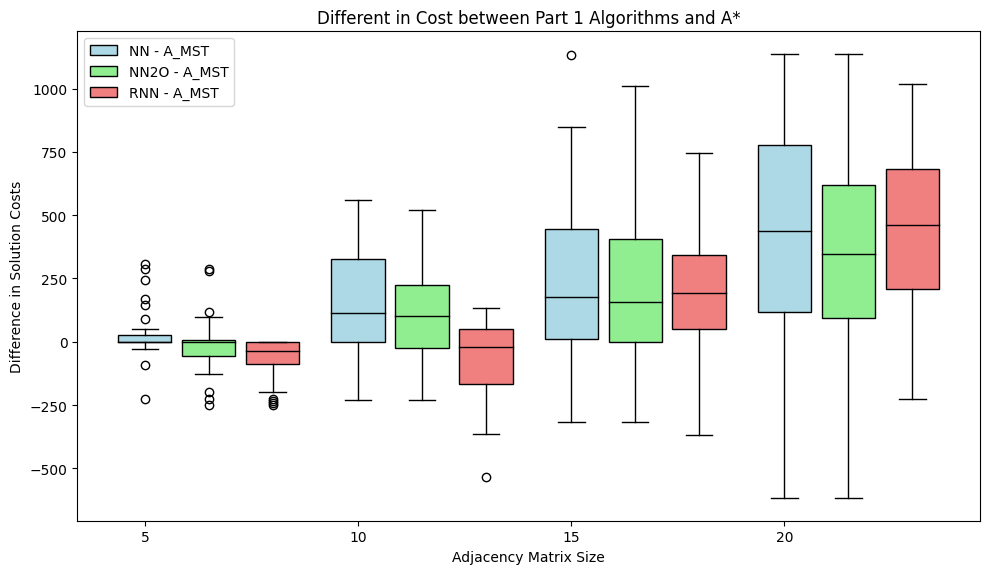

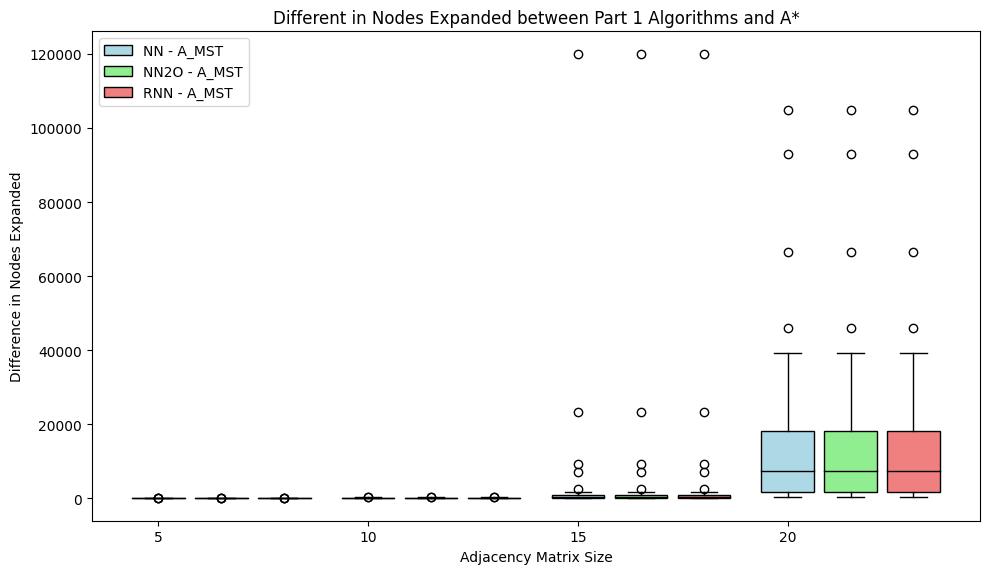

In [179]:
def plot_box_plots(df, metric, title, ylabel):
    # Define a color palette for each algorithm
    algorithm_colors = {
        'NN - A_MST': 'lightblue',
        'NN2O - A_MST': 'lightgreen',
        'RNN - A_MST': 'lightcoral'
    }

    # Prepare a figure
    plt.figure(figsize=(10, 6))

    # Get the unique node sizes and algorithms
    size = df['Size'].unique()
    algorithms = df['Algorithm'].unique()

    # Create a list to store plot handles for the legend
    plot_handles = []

    # Iterate through algorithms and add box plots for each
    for algorithm in algorithms:
        # Filter the dataframe by the current algorithm
        data = df[df['Algorithm'] == algorithm]

        # Create a boxplot for the current algorithm, colored accordingly
        box = plt.boxplot(
            [data[data['Size'] == n][metric] for n in size],
            positions=np.arange(len(size)) + (0.3 * list(algorithms).index(algorithm)),
            widths=0.25,
            patch_artist=True,
            boxprops=dict(facecolor=algorithm_colors[algorithm], color='black'),
            medianprops=dict(color='black'),
            whiskerprops=dict(color='black'),
            capprops=dict(color='black'),
            flierprops=dict(markeredgecolor='black'),
            manage_ticks=False
        )

        # Store the handle for the legend
        plot_handles.append(box["boxes"][0])

    # Set x-axis labels
    plt.xticks(np.arange(len(size)), labels=size)

    # Title and labels
    plt.title(title)
    plt.suptitle('')  # Remove automatic matplotlib title
    plt.xlabel("Adjacency Matrix Size")
    plt.ylabel(ylabel)

    # Add legend
    plt.legend(plot_handles, algorithms, loc='upper left')

    # Show the plot
    plt.tight_layout()
    plt.show()

# Plot box plots for total cost, CPU time, and real time
plot_box_plots(df, 'TotalCost', 'Different in Cost between Part 1 Algorithms and A*', 'Difference in Solution Costs')
plot_box_plots(df, 'Nodes_Expanded', 'Different in Nodes Expanded between Part 1 Algorithms and A*', 'Difference in Nodes Expanded')


# Hill-climbing

In [180]:
# Hill-climbing
def hillClimbing(adj_matrix, start_route):
    current_route = start_route
    current_distance = calculate_total_distance(adj_matrix, current_route)
    best_route = current_route
    best_distance = current_distance

    # While new solution better than old solution
    while True:
        found_better_neighbor = False
        # Find solution “neighbors”
        for i in range(len(current_route) - 1):
            for j in range(i + 1, len(current_route)):
                # Swap two values in the route to find neighbors
                neighbor_route = two_opt_swap(current_route, i, j)
                neighbor_distance = calculate_total_distance(adj_matrix, neighbor_route)

                # Get the best neighbor
                if neighbor_distance < best_distance:
                    best_route = neighbor_route
                    best_distance = neighbor_distance
                    found_better_neighbor = True

        # If best neighbor is better than solution: solution = best neighbor
        if found_better_neighbor:
            current_route = best_route
            current_distance = best_distance
        else:
            break

    return best_route, best_distance

# Simulated Annealing

In [181]:
# Simulated annealing algorithm
def simuAnnealing(adj_matrix, initial_route, temperature, cooling_rate, max_iterations):
    current_route = initial_route
    current_distance = calculate_total_distance(adj_matrix, current_route)
    best_route = current_route
    best_distance = current_distance

    # Implement max_iterations to prevent float errors instead of temperature > 0
    for _ in range(max_iterations):
        # Get a random “neighbor”
        i, j = random.sample(range(len(current_route)), 2)
        neighbor_route = two_opt_swap(current_route, i, j)
        neighbor_distance = calculate_total_distance(adj_matrix, neighbor_route)

        # Calculate the difference in cost
        cost_diff = neighbor_distance - current_distance

        # If neighbor better than solution: accept as new solution
        # Else, accept with probability (exp(-(E - Ei) / Ti)):
        if cost_diff < 0 or random.random() < np.exp(-cost_diff / temperature):
            current_route = neighbor_route
            current_distance = neighbor_distance

            # Update the best solution found so far
            if current_distance < best_distance:
                best_route = current_route
                best_distance = current_distance

        # Cool down the temperature (T = T * alpha)
        temperature *= cooling_rate

    return best_route, best_distance

# Genetic Algorithm

In [182]:
# Make a random initial population
def generate_initial_population(adj_matrix, population_size):
    num_cities = len(adj_matrix)
    population = []
    for _ in range(population_size):
        route = list(range(num_cities))
        random.shuffle(route)
        population.append(route)
    return population

# Population fitness function
def fitness_function(max_cost, solution_cost):
    return max_cost - solution_cost

# # Selection approach
def selection(population, adj_matrix, num_parents):
  # Get costs for each solution in the population:
  costs = [calculate_total_distance(adj_matrix, route) for route in population]
  # Get fitness scores for each solution in the population (maximum cost - solution cost):
  fitness_values = [fitness_function(np.argmax(costs), cost) for cost in costs]

  # Fitness probability = fitness / σ population fitness
  fitness_probs = [fitness_values[i] / sum(fitness_values) for i in range(len(fitness_values))]
  # Select parents according to their fitness probabilities
  selected_indices = [np.random.choice(range(len(fitness_probs)), p=fitness_probs) for _ in range(len(population))]
  selected_population = [population[i] for i in selected_indices]
  return selected_population

# Length of crossover
def crossover(parent1, parent2):
    # Randomly select a subset of the route
    crossover_point = random.randint(1, len(parent1) - 1)
    # From Parent 1, map the subset directly onto the child
    child1 = parent1[:crossover_point]
    # Add route from Parent 2 in order. If the city is already in the child route
    # at index i, add the city from index i in Parent 2
    for gene in parent2:
        if gene not in child1:
            child1.append(gene)
    return child1

# Mutate
def mutation(route, mutation_rate):
    # Swap nodes if within mutation probability
    if random.random() < mutation_rate:
        i = random.randint(0, len(route) - 1)
        j = random.randint(0, len(route) - 1)
        route[i], route[j] = route[j], route[i]
    return route

# Genetic algorithm
def genetic(adj_matrix, population_size, num_generations, num_parents, mutation_rate):
    population = generate_initial_population(adj_matrix, population_size)
    best_route = None
    best_distance = float('inf')

    # While generations < num_generations
    for _ in range(num_generations):
        # Choose 2 parents according to population fitness function
        parents = selection(population, adj_matrix, num_parents)
        new_population = []

        # For population size / 2
        for i in range(0, len(parents), 2):
            if i + 1 < len(parents):
                # Crossover parents to generate children
                child1 = crossover(parents[i], parents[i + 1])
                child2 = crossover(parents[i + 1], parents[i])
                # Mutate
                child1 = mutation(child1, mutation_rate)
                child2 = mutation(child2, mutation_rate)
                new_population.extend([child1, child2])

        # Add the new routes to the population
        population = new_population
        # Choose the best routes to stay in the population (maintaining population size)
        for route in population:
            distance = calculate_total_distance(adj_matrix, route)
            if distance < best_distance:
                best_distance = distance
                best_route = route

    # Return the best solution from the population
    return best_route, best_distance


# Compute difference between each graph's total cost from each local search algorithm and optimal cost from A* with MST

In [183]:
# Run hillClimbing, simuAnnealing, and genetic algorithms and return their results.
def run_algorithms(adj_matrix, total_cities):

    results = {}
    # Set an initial random solution
    initial_route = list(range(total_cities))
    random.shuffle(initial_route)

    # Run Hill Climbing
    start_time = time.time()
    hc_route, hc_cost = hillClimbing(adj_matrix, initial_route)
    hc_cpu_time = time.process_time()
    hc_real_time = time.time() - start_time
    results['hillClimbing'] = (hc_cost, hc_cpu_time, hc_real_time)

    # Run Simulated Annealing
    start_time = time.time()
    sa_route, sa_cost = simuAnnealing(adj_matrix, initial_route, temperature=1000, cooling_rate=0.995, max_iterations=10000)
    sa_cpu_time = time.process_time()
    sa_real_time = time.time() - start_time
    results['simuAnnealing'] = (sa_cost, sa_cpu_time, sa_real_time)

    # Run Genetic Algorithm
    start_time = time.time()
    g_route, g_cost = genetic(adj_matrix, population_size=50, num_generations=100, num_parents=20, mutation_rate=0.05)
    g_cpu_time = time.process_time()
    g_real_time = time.time() - start_time
    results['genetic'] = (g_cost, g_cpu_time, g_real_time)

    return results

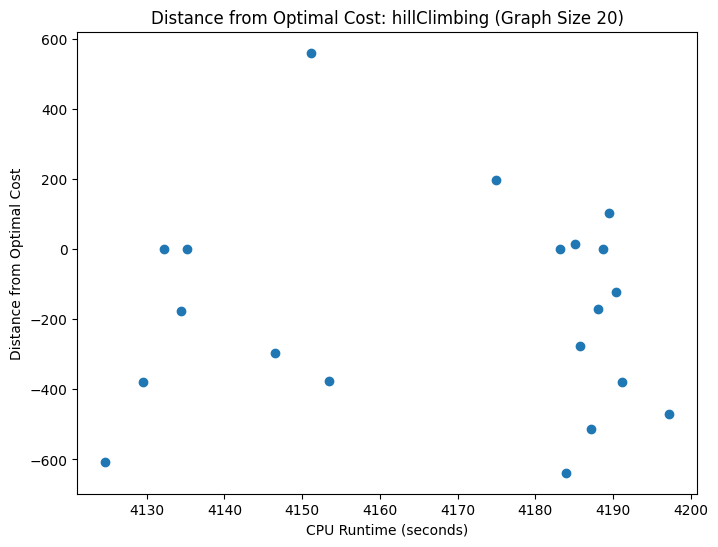

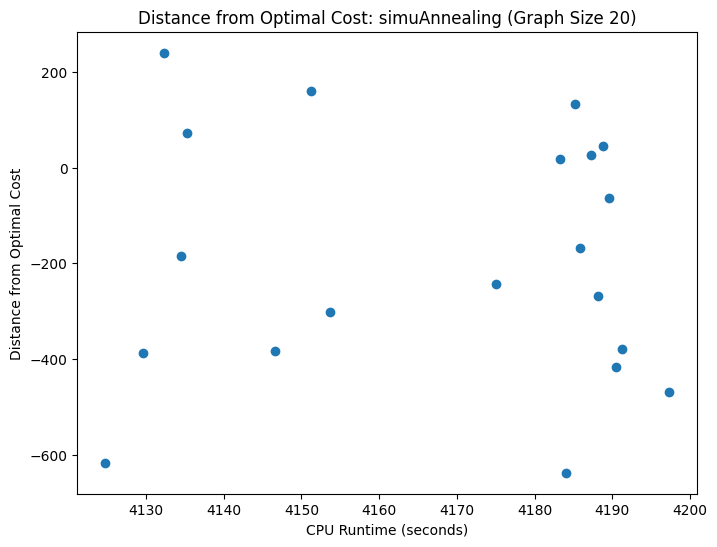

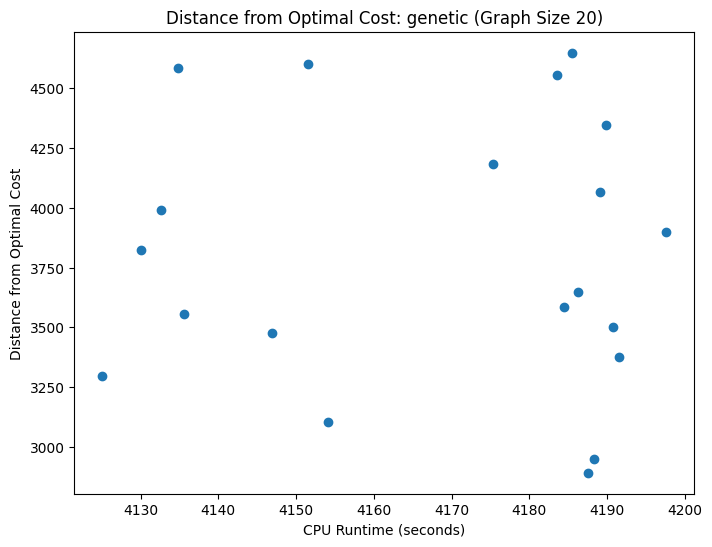

In [191]:
# Data collection
all_results = []
sizes = ['20']  # Only graph size 20
nums = ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20']

graphs = []
for size in sizes:
  for num in nums:
    filename = f'/content/infile{size}_{num}.txt'
    adj_matrix, total_cities = read_adjacency_matrix(filename)
    graphs.append((adj_matrix, total_cities))


for graph, n in graphs:
    results = run_algorithms(graph, n)
    amst_route, amst_cost, amst_nodes_expanded = A_MST(graph)

    for alg, (cost, cpu_time, real_time) in results.items():
        all_results.append({
            'Algorithm': alg,
            'Size': n,
            'CPU_Time': cpu_time,
            'Real_Time': real_time,
            'TotalCost': cost,
            'OptimalCost': amst_cost,
            'CostDifference': cost - amst_cost
        })

# Convert to DataFrame for easier analysis
df = pd.DataFrame(all_results)

# Plot scatterplots for each local search algorithm
algorithms = ['hillClimbing', 'simuAnnealing', 'genetic']
for algorithm in algorithms:
    data = df[df['Algorithm'] == algorithm]
    plt.figure(figsize=(8, 6))
    plt.scatter(data['CPU_Time'], data['CostDifference'])
    plt.title(f"Distance from Optimal Cost: {algorithm} (Graph Size 20)")
    plt.xlabel("CPU Runtime (seconds)")
    plt.ylabel("Distance from Optimal Cost")
    plt.show()
